In [1]:
import os
import numpy as np
import pandas as pd
import re
import glob   # glob是python自带的一个操作文件的相关模块
import seaborn as sns
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt

## 驱虫市场的潜力分析

- 切换目录

In [2]:
os.chdir(r'E:\千锋上海\data\驱虫剂市场')

- 获取符合条件的文件名

In [3]:
filenames = glob.glob("*市场近三年交易额.xlsx")
filenames

['灭鼠杀虫剂市场近三年交易额.xlsx',
 '电蚊香套装市场近三年交易额.xlsx',
 '盘香灭蟑香蚊香盘市场近三年交易额.xlsx',
 '蚊香加热器市场近三年交易额.xlsx',
 '蚊香液市场近三年交易额.xlsx',
 '蚊香片市场近三年交易额.xlsx',
 '防霉防蛀片市场近三年交易额.xlsx']

- 定义一个读取excel文件的函数，提取一部分文件名作为新列名；修正时间格式；设置时间为索引

In [4]:
def read_threeyears_excel(filename):
    colname = re.search(r'.*(?=市场)',filename).group() # 提取“市场”前面的文字内容
    df = pd.read_excel(filename)
    if df['时间'].dtypes == 'int64':
        # 将“时间”列的数据格式转换为datetime
        df['时间'] = pd.to_datetime(df['时间'],unit='D',origin=pd.Timestamp('1899-12-30'))
    df.rename(columns={df.columns[1]:colname},inplace=True)  # 对列名称进行转换
    df.set_index('时间',inplace=True)  # 将“时间”列作为索引
    return df

- 分别读取每个文件，转成DataFrame后，存入列表中

In [5]:
dfs = [read_threeyears_excel(filename) for filename in filenames]

In [6]:
df = pd.concat(dfs,axis=1).reset_index()   # 拼接，并重置索引
df.head()

,时间,灭鼠杀虫剂,电蚊香套装,盘香灭蟑香蚊香盘,蚊香加热器,蚊香液,蚊香片,防霉防蛀片
0,2018-10-01,1.136548e+08,106531.29,4171283.35,315639.48,7814546.15,1032414.29,8541153.59
1,2018-09-01,1.440261e+08,105666.63,6784500.17,457366.41,10654973.47,1566651.88,8825870.43
2,2018-08-01,1.540426e+08,201467.03,10709683.41,746513.13,17835577.80,2617149.00,6320153.44
3,2018-07-01,1.480032e+08,438635.29,16589184.89,1871757.00,38877917.83,6209040.06,6302595.06
4,2018-06-01,1.359438e+08,953749.78,23526385.73,3641025.92,76499091.86,12484919.63,7047206.98


### 清洗数据

In [7]:
df.isna().mean()

时间          0.0
灭鼠杀虫剂       0.0
电蚊香套装       0.0
盘香灭蟑香蚊香盘    0.0
蚊香加热器       0.0
蚊香液         0.0
蚊香片         0.0
防霉防蛀片       0.0
dtype: float64

In [8]:
month = df['时间'].dt.month   # 抽取月份，以供后面的代码使用
month

0     10
1      9
2      8
3      7
4      6
5      5
6      4
7      3
8      2
9      1
10    12
11    11
12    10
13     9
14     8
15     7
16     6
17     5
18     4
19     3
20     2
21     1
22    12
23    11
24    10
25     9
26     8
27     7
28     6
29     5
30     4
31     3
32     2
33     1
34    12
35    11
Name: 时间, dtype: int64

In [9]:
for i in [11,12]:   # 分别预测11月，12月的销售金额
    dm = df[month == i]   # 选择对应月份的行，作为新的DataFrame
    Xtrain = np.array(dm['时间'].dt.year).reshape(-1,1)  # 训练集特征
    yhat = [pd.datetime(2018,i,1)]
    for j in range(1,len(dm.columns)):   # 遍历列
        ytrain = np.array(dm.iloc[:,j])  # 训练集标签
        reg = LinearRegression().fit(Xtrain,ytrain)  # 线性回归，拟合训练
        yhat_single = reg.predict(np.array([2018]).reshape(-1,1))
        yhat.append(yhat_single)
    newrow = pd.DataFrame(dict(zip(df.columns,yhat))) # 创建新的DataFrame
    df = newrow.append(df)  # 添加新行

E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [10]:
df.head()

,时间,灭鼠杀虫剂,电蚊香套装,盘香灭蟑香蚊香盘,蚊香加热器,蚊香液,蚊香片,防霉防蛀片
0,2018-12-01,5.256763e+07,50204.53,9.285543e+05,86849.166667,3.081492e+06,4.268126e+05,3958717.58
0,2018-11-01,7.175250e+07,38692.61,1.801319e+06,193874.386667,5.543204e+06,7.766270e+05,6678677.55
0,2018-10-01,1.136548e+08,106531.29,4.171283e+06,315639.480000,7.814546e+06,1.032414e+06,8541153.59
1,2018-09-01,1.440261e+08,105666.63,6.784500e+06,457366.410000,1.065497e+07,1.566652e+06,8825870.43
2,2018-08-01,1.540426e+08,201467.03,1.070968e+07,746513.130000,1.783558e+07,2.617149e+06,6320153.44


In [11]:
df.reset_index(drop=True,inplace=True)
df.head()

,时间,灭鼠杀虫剂,电蚊香套装,盘香灭蟑香蚊香盘,蚊香加热器,蚊香液,蚊香片,防霉防蛀片
0,2018-12-01,5.256763e+07,50204.53,9.285543e+05,86849.166667,3.081492e+06,4.268126e+05,3958717.58
1,2018-11-01,7.175250e+07,38692.61,1.801319e+06,193874.386667,5.543204e+06,7.766270e+05,6678677.55
2,2018-10-01,1.136548e+08,106531.29,4.171283e+06,315639.480000,7.814546e+06,1.032414e+06,8541153.59
3,2018-09-01,1.440261e+08,105666.63,6.784500e+06,457366.410000,1.065497e+07,1.566652e+06,8825870.43
4,2018-08-01,1.540426e+08,201467.03,1.070968e+07,746513.130000,1.783558e+07,2.617149e+06,6320153.44


In [12]:
df = df[df['时间'].dt.year != 2015]

## 驱虫市场潜力分析

- 添加新列colsum,统计各种商品每月的总销售金额

In [13]:
df['colsum'] = df.sum(1)
df.head()

,时间,灭鼠杀虫剂,电蚊香套装,盘香灭蟑香蚊香盘,蚊香加热器,蚊香液,蚊香片,防霉防蛀片,colsum
0,2018-12-01,5.256763e+07,50204.53,9.285543e+05,86849.166667,3.081492e+06,4.268126e+05,3958717.58,6.110026e+07
1,2018-11-01,7.175250e+07,38692.61,1.801319e+06,193874.386667,5.543204e+06,7.766270e+05,6678677.55,8.678489e+07
2,2018-10-01,1.136548e+08,106531.29,4.171283e+06,315639.480000,7.814546e+06,1.032414e+06,8541153.59,1.356363e+08
3,2018-09-01,1.440261e+08,105666.63,6.784500e+06,457366.410000,1.065497e+07,1.566652e+06,8825870.43,1.724211e+08
4,2018-08-01,1.540426e+08,201467.03,1.070968e+07,746513.130000,1.783558e+07,2.617149e+06,6320153.44,1.924731e+08


- 插入年份列year,提取时间列中的年份到该列中

In [14]:
df.insert(1,'year',df['时间'].dt.year)

In [15]:
byyear = df.groupby("year").sum().reset_index()
byyear

,year,灭鼠杀虫剂,电蚊香套装,盘香灭蟑香蚊香盘,蚊香加热器,蚊香液,蚊香片,防霉防蛀片,colsum
0,2016,6.080471e+08,7666572.12,4.785285e+07,5.905205e+06,1.704905e+08,27980839.47,50023001.94,9.179661e+08
1,2017,8.477740e+08,9377531.68,8.635539e+07,1.055284e+07,3.300656e+08,49068587.96,62678822.18,1.395873e+09
2,2018,1.137893e+09,4537682.09,1.180885e+08,1.683672e+07,3.582077e+08,51845921.56,72701365.23,1.760111e+09


- 按照年份绘制总体销售额趋势

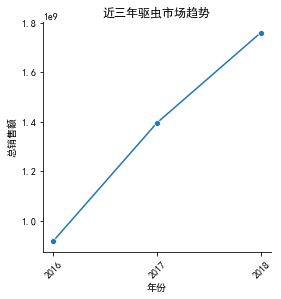

In [16]:
plt.rcParams['font.sans-serif'] = 'simhei'
sns.relplot('year','colsum',data=byyear,kind='line',marker='o',height=4)
plt.title("近三年驱虫市场趋势")
plt.xticks(byyear.year,rotation=45)  # 设置x坐标轴刻度
plt.xlabel("年份")
plt.ylabel("总销售额")
plt.show()

- 分析各类目市场销量趋势分析

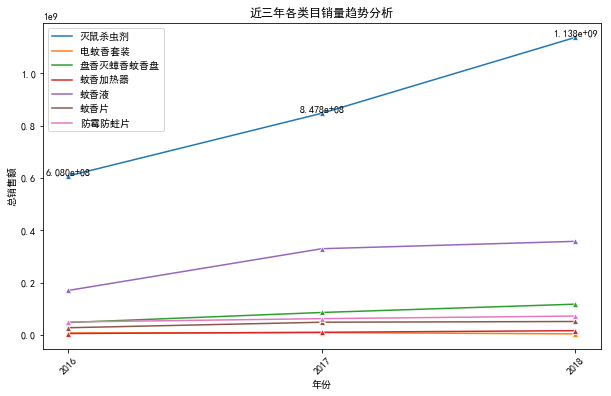

In [17]:
# 设置图形大小
plt.subplots(figsize=(10,6))
# dashes=False 不区分线型
sns.lineplot(data=byyear.set_index("year").iloc[:,:-1],marker='^',dashes=False)
for x,y in zip(byyear['year'],byyear['灭鼠杀虫剂']):  # 给“灭鼠杀虫剂”线条上添加文本
    plt.text(x,y,'%.3e'%y,ha='center',va='bottom')

plt.title("近三年各类目销量趋势分析")
plt.xticks(byyear.year,rotation=45)  # 设置x坐标轴刻度
plt.xlabel("年份")
plt.ylabel("总销售额")
plt.show()

In [18]:
byyear

,year,灭鼠杀虫剂,电蚊香套装,盘香灭蟑香蚊香盘,蚊香加热器,蚊香液,蚊香片,防霉防蛀片,colsum
0,2016,6.080471e+08,7666572.12,4.785285e+07,5.905205e+06,1.704905e+08,27980839.47,50023001.94,9.179661e+08
1,2017,8.477740e+08,9377531.68,8.635539e+07,1.055284e+07,3.300656e+08,49068587.96,62678822.18,1.395873e+09
2,2018,1.137893e+09,4537682.09,1.180885e+08,1.683672e+07,3.582077e+08,51845921.56,72701365.23,1.760111e+09


- 各类目市场销售总额占比

In [19]:
byyear_per = byyear.iloc[:,1:-1].div(byyear["colsum"],axis=0)
byyear_per

,灭鼠杀虫剂,电蚊香套装,盘香灭蟑香蚊香盘,蚊香加热器,蚊香液,蚊香片,防霉防蛀片
0,0.662385,0.008352,0.052129,0.006433,0.185726,0.030481,0.054493
1,0.607343,0.006718,0.061865,0.007560,0.236458,0.035153,0.044903
2,0.646489,0.002578,0.067092,0.009566,0.203514,0.029456,0.041305


In [20]:
byyear_per.index = byyear.year
byyear_per

,灭鼠杀虫剂,电蚊香套装,盘香灭蟑香蚊香盘,蚊香加热器,蚊香液,蚊香片,防霉防蛀片
year,,,,,,,
2016,0.662385,0.008352,0.052129,0.006433,0.185726,0.030481,0.054493
2017,0.607343,0.006718,0.061865,0.007560,0.236458,0.035153,0.044903
2018,0.646489,0.002578,0.067092,0.009566,0.203514,0.029456,0.041305


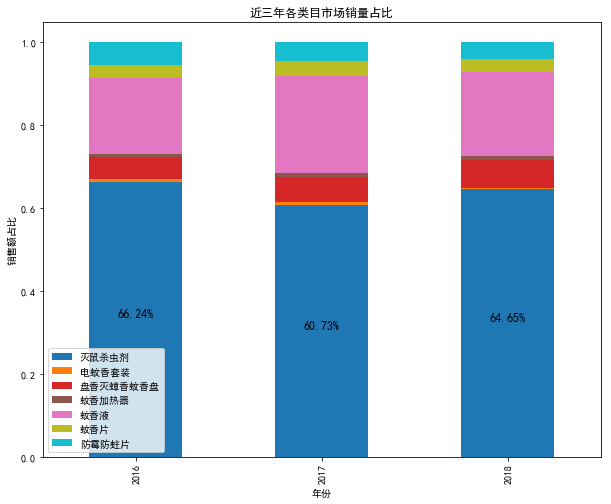

In [21]:
byyear_per.plot(kind='bar',stacked=True,figsize=(10,8),colormap="tab10")
plt.title("近三年各类目市场销量占比")
for x,y in zip(range(len(byyear_per)),byyear_per["灭鼠杀虫剂"]):
    plt.text(x,y/2,str(round(y*100,2))+"%",ha='center',va='bottom',size=12)
plt.xlabel("年份")
plt.ylabel("销售额占比")
plt.show()

In [22]:
byyear

,year,灭鼠杀虫剂,电蚊香套装,盘香灭蟑香蚊香盘,蚊香加热器,蚊香液,蚊香片,防霉防蛀片,colsum
0,2016,6.080471e+08,7666572.12,4.785285e+07,5.905205e+06,1.704905e+08,27980839.47,50023001.94,9.179661e+08
1,2017,8.477740e+08,9377531.68,8.635539e+07,1.055284e+07,3.300656e+08,49068587.96,62678822.18,1.395873e+09
2,2018,1.137893e+09,4537682.09,1.180885e+08,1.683672e+07,3.582077e+08,51845921.56,72701365.23,1.760111e+09


- 查看各类目市场年增幅

In [23]:
byyear0 = byyear.iloc[:,1:-1]
byyear0

,灭鼠杀虫剂,电蚊香套装,盘香灭蟑香蚊香盘,蚊香加热器,蚊香液,蚊香片,防霉防蛀片
0,6.080471e+08,7666572.12,4.785285e+07,5.905205e+06,1.704905e+08,27980839.47,50023001.94
1,8.477740e+08,9377531.68,8.635539e+07,1.055284e+07,3.300656e+08,49068587.96,62678822.18
2,1.137893e+09,4537682.09,1.180885e+08,1.683672e+07,3.582077e+08,51845921.56,72701365.23


In [24]:
byyear_diff = byyear0.diff().iloc[1:,:].reset_index(drop=True) / byyear0.iloc[:2,:]
byyear_diff.index = ['16-17','17-18']
byyear_diff

,灭鼠杀虫剂,电蚊香套装,盘香灭蟑香蚊香盘,蚊香加热器,蚊香液,蚊香片,防霉防蛀片
16-17,0.394257,0.223171,0.804603,0.787041,0.935976,0.753650,0.253000
17-18,0.342213,-0.516111,0.367471,0.595468,0.085262,0.056601,0.159903


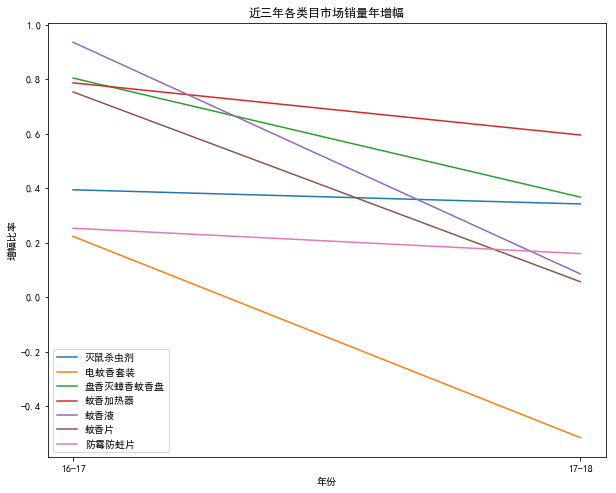

In [25]:
plt.rcParams['axes.unicode_minus'] =False   # 解决负号不显示问题
plt.subplots(figsize=(10,8))
sns.lineplot(data=byyear_diff,dashes=False)
plt.title("近三年各类目市场销量年增幅")
plt.xlabel("年份")
plt.ylabel("增幅比率")
plt.show()

In [26]:
byyear0.diff()

,灭鼠杀虫剂,电蚊香套装,盘香灭蟑香蚊香盘,蚊香加热器,蚊香液,蚊香片,防霉防蛀片
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.397269e+08,1710959.56,3.850254e+07,4.647636e+06,1.595750e+08,21087748.49,12655820.24
2,2.901194e+08,-4839849.59,3.173312e+07,6.283882e+06,2.814215e+07,2777333.60,10022543.05


- 直观的查看灭鼠杀虫剂近三年的增量（不算比例了）趋势

E:\Anaconda3\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
E:\Anaconda3\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


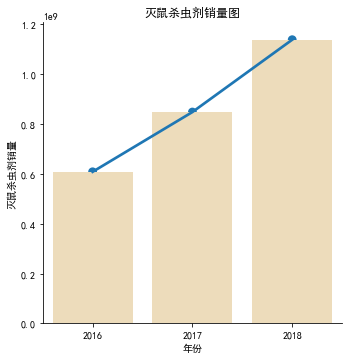

In [27]:
g = sns.FacetGrid(byyear,height=5)
g.map(sns.barplot,'year','灭鼠杀虫剂',color='wheat')
g.map(sns.pointplot,'year','灭鼠杀虫剂')
plt.title("灭鼠杀虫剂销量图")
plt.xlabel("年份")
plt.ylabel("灭鼠杀虫剂销量")
plt.show()

## 市场集中度描述

- 读取“top100品牌数据.xlsx”文件

In [28]:
df_top100 = pd.read_excel('top100品牌数据.xlsx')
df_top100.head()

,品牌,行业排名,交易指数,交易增长幅度,支付转化指数,操作
0,PREMISE/拜灭士,1,530344,-0.3235,1521,趋势分析
1,科凌虫控,2,474937,-0.1910,1581,趋势分析
2,ARS/安速,3,402372,-0.2682,1448,趋势分析
3,思乐智,4,360780,0.2056,841,趋势分析
4,希诺,5,346656,-0.1085,1865,趋势分析


In [29]:
df_top100.describe()

,行业排名,交易指数,交易增长幅度,支付转化指数
count,100.000000,100.000000,100.000000,100.000000
mean,50.500000,147327.560000,0.395790,1247.870000
std,29.011492,88177.182391,2.038278,350.304014
min,1.000000,65194.000000,-0.781900,577.000000
25%,25.750000,86129.000000,-0.266325,967.750000
50%,50.500000,118682.500000,-0.061800,1245.000000
75%,75.250000,163373.250000,0.334350,1491.500000
max,100.000000,530344.000000,17.675100,2000.000000


- 创建“交易指数占比”列（该列代表了市场占有率）

In [30]:
df_top100["交易指数占比"] = df_top100["交易指数"] / df_top100["交易指数"].sum()

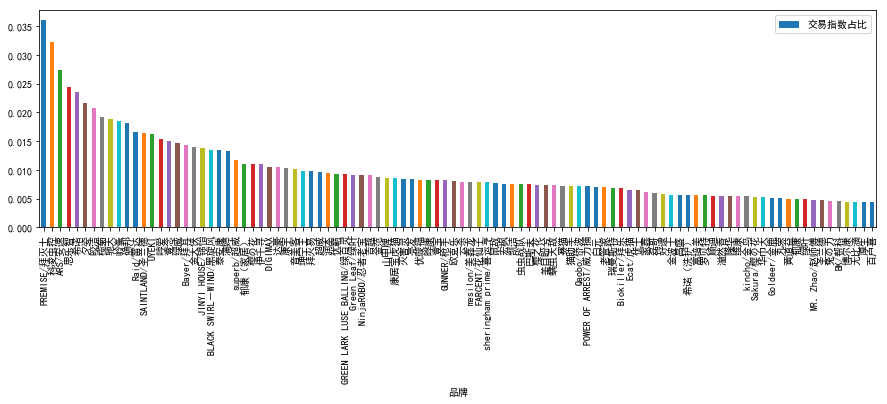

In [31]:
df_top100.plot(x="品牌",y="交易指数占比",kind="bar",figsize=(15,4))
plt.show()

- 计算HHI

In [32]:
HHI = sum(df_top100["交易指数占比"] ** 2)
print("计算的HHI是：",HHI)

计算的HHI是： 0.013546334007208914


## 灭鼠杀虫剂机会点分析

### 加载数据，清洗数据

In [33]:
# 切换目录
os.chdir(r'E:\千锋上海\data\灭鼠杀虫剂细分市场') 

In [34]:
filenames1 = glob.glob("*.xlsx")
filenames1

['杀虫.xlsx', '灭鼠.xlsx', '虱子.xlsx', '螨.xlsx', '蟑螂.xlsx']

In [35]:
dfs1 = [pd.read_excel(fname) for fname in filenames1]

In [36]:
df2 = pd.concat(dfs1,sort=False)   # 合并文件为一个DataFrame

In [37]:
# 查看缺失值
df2.isna().mean()

类别             0.000000
时间             0.000000
页码             0.000000
排名             0.000000
链接             0.000000
主图链接           0.000000
主图视频链接         0.746797
宝贝标题           0.000000
宝贝ID           0.000000
销量（人数）         0.000000
售价             0.000000
预估销售额          0.005491
运费             0.000000
评价人数           0.022880
收藏人数           0.000000
下架时间           0.000000
类目             0.000000
地域             0.406955
旺旺             0.000000
店铺类型           0.000000
信誉             1.000000
DSR_物流分        1.000000
DSR_物流行业对比     1.000000
DSR_描述分        1.000000
DSR_描述行业对比     1.000000
DSR_服务分        1.000000
DSR_服务行业对比     1.000000
品牌             0.095333
型号             0.423276
净含量            0.421599
                 ...   
3C规格型号         0.999237
吸尘器类型          0.998932
储尘类型           0.998932
线长             0.998932
特殊吸嘴类型         0.999237
功率             0.998932
吸尘器品牌          0.998932
小狗吸尘器型号        1.000000
申请人名称          1.000000
制造商名称          1.000000
3C产品型号         1

- 删除缺失值占比超过98%的特征

In [38]:
col_index1 = df2.isna().mean() > 0.98
df21 = df2.loc[:,~col_index1]

- 删除特征值完全一致的特征

In [39]:
col_index2 = np.array([df21[col].nunique()==1 for col in df21.columns])
df22 = df21.loc[:,~col_index2]

- 药品登记号后的列缺失值占比高,都删除

In [40]:
col_index3 = df22.columns.get_loc("药品登记号")
df23 = df22.iloc[:,:col_index3]
col_index3

24

In [41]:
df23.columns

Index(['类别', '时间', '页码', '排名', '链接', '主图链接', '主图视频链接', '宝贝标题', '宝贝ID',
       '销量（人数）', '售价', '预估销售额', '运费', '评价人数', '收藏人数', '下架时间', '地域', '旺旺',
       '店铺类型', '品牌', '型号', '净含量', '适用对象', '物理形态'],
      dtype='object')

- 依据逻辑删除不可能会用到的列

In [42]:
useless = ['时间','链接','主图链接','主图视频链接',
'页码','排名','宝贝标题','运费','下架时间','旺旺']
df24 = df23.drop(columns=useless)

- 查看清洗之后的数据属性

In [43]:
df24.isna().mean()

类别        0.000000
宝贝ID      0.000000
销量（人数）    0.000000
售价        0.000000
预估销售额     0.005491
评价人数      0.022880
收藏人数      0.000000
地域        0.406955
店铺类型      0.000000
品牌        0.095333
型号        0.423276
净含量       0.421599
适用对象      0.279896
物理形态      0.286303
dtype: float64

In [44]:
df24.dtypes

类别         object
宝贝ID        int64
销量（人数）      int64
售价        float64
预估销售额     float64
评价人数      float64
收藏人数        int64
地域         object
店铺类型       object
品牌         object
型号         object
净含量        object
适用对象       object
物理形态       object
dtype: object

- 宝贝ID列是整数不合理,这里将类型改为object

In [45]:
df24 = df24.astype({"宝贝ID":'object'})
df24.reset_index(drop=True,inplace=True)
df24.describe()

,销量（人数）,售价,预估销售额,评价人数,收藏人数
count,6556.000000,6556.000000,6.520000e+03,6406.000000,6556.000000
mean,324.518609,39.559527,1.032676e+04,1942.746800,1345.778981
std,3207.470186,49.678113,7.851193e+04,13493.925308,6947.250438
min,0.000000,0.010000,1.000000e-02,0.000000,0.000000
25%,14.000000,13.900000,2.307375e+02,36.000000,33.000000
50%,26.000000,25.800000,6.741000e+02,160.000000,133.000000
75%,70.000000,48.000000,2.288000e+03,602.750000,496.500000
max,143037.000000,618.000000,2.672898e+06,502295.000000,234645.000000


In [46]:
df24.head()

,类别,宝贝ID,销量（人数）,售价,预估销售额,评价人数,收藏人数,地域,店铺类型,品牌,型号,净含量,适用对象,物理形态
0,杀虫,578459866289,99,29.9,2960.1,26.0,202,NaN,天猫,拜耳,特姆得,NaN,蟑螂,液体
1,杀虫,548196868239,99,0.6,59.4,1330.0,242,浙江 金华,淘宝,佰凌,180325,NaN,NaN,NaN
2,杀虫,580839295562,99,98.0,9702.0,44.0,27,广东 深圳,淘宝,NaN,NaN,NaN,NaN,NaN
3,杀虫,580264662322,99,6.9,683.1,24.0,26,河南 商丘,淘宝,SHURONGCROP/树荣作物,NaN,30g,NaN,NaN
4,杀虫,44484517973,99,18.8,1861.2,121.0,133,河北 秦皇岛,天猫,Raid/雷达,雷达杀虫气雾剂清香,600ml,蟑螂,喷雾


- 通过类别分组，求不同类别的“预估销售额”

In [47]:
byclass = df24["预估销售额"].groupby(df24['类别']).sum()
byclass

类别
杀虫     8207628.10
灭鼠    25686011.99
虱      4512886.01
螨     10886752.88
蟑螂    18037223.68
Name: 预估销售额, dtype: float64

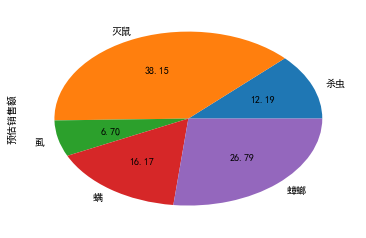

In [48]:
byclass.plot.pie(autopct="%.2f")
plt.show()

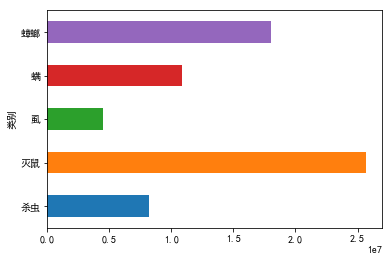

In [49]:
byclass.plot.barh()
plt.show()

In [50]:
df24.head()

,类别,宝贝ID,销量（人数）,售价,预估销售额,评价人数,收藏人数,地域,店铺类型,品牌,型号,净含量,适用对象,物理形态
0,杀虫,578459866289,99,29.9,2960.1,26.0,202,NaN,天猫,拜耳,特姆得,NaN,蟑螂,液体
1,杀虫,548196868239,99,0.6,59.4,1330.0,242,浙江 金华,淘宝,佰凌,180325,NaN,NaN,NaN
2,杀虫,580839295562,99,98.0,9702.0,44.0,27,广东 深圳,淘宝,NaN,NaN,NaN,NaN,NaN
3,杀虫,580264662322,99,6.9,683.1,24.0,26,河南 商丘,淘宝,SHURONGCROP/树荣作物,NaN,30g,NaN,NaN
4,杀虫,44484517973,99,18.8,1861.2,121.0,133,河北 秦皇岛,天猫,Raid/雷达,雷达杀虫气雾剂清香,600ml,蟑螂,喷雾


## 灭鼠类别分析

- 获取灭鼠类别数据

In [51]:
df25 = df24[df24['类别']=='灭鼠']

- 依据售价进行价格区间划分

In [52]:
bins = [0,50,100,150,200,250,300,500]
labels = ['0_50','50_100','100_150','150_200','200_250','250_300','300以上']
df25['价格区间'] = pd.cut(df25['售价'],bins=bins,labels=labels,include_lowest=True)

E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [53]:
df25['价格区间'].value_counts()

0_50       1138
50_100      242
100_150      62
150_200      35
300以上        28
250_300       9
200_250       9
Name: 价格区间, dtype: int64

- 编写函数，计算各价格区间的预估销售额,销售额占比,宝贝数,宝贝数占比,单宝贝平均销售额，相对竞争度(单宝贝平均销售额的反面)

In [54]:
def by_fun(df,by,sort='单宝贝平均销售额'):
    byclass = df.groupby(by).sum().loc[:,['预估销售额']]  # 注意：这一步获取的是DataFrame
    byclass['销售额占比'] = byclass['预估销售额'] / byclass['预估销售额'].sum()
    byclass['宝贝数'] = df.groupby(by).nunique()['宝贝ID']
    byclass['宝贝数占比'] = byclass['宝贝数'] / byclass['宝贝数'].sum()
    byclass['单宝贝平均销售额'] = byclass['预估销售额'] / byclass['宝贝数']
    byclass['相对竞争度'] =  1 - (byclass['单宝贝平均销售额'] - byclass['单宝贝平均销售额'].min()) /(byclass['单宝贝平均销售额'].max() - byclass['单宝贝平均销售额'].min())
    if sort:
        byclass.sort_values(sort,ascending=False,inplace=True)
    return byclass

In [55]:
byprice = by_fun(df25,'价格区间')
byprice

,预估销售额,销售额占比,宝贝数,宝贝数占比,单宝贝平均销售额,相对竞争度
价格区间,,,,,,
200_250,2743758.00,0.106819,7,0.006173,391965.428571,0.000000
100_150,2758086.29,0.107377,46,0.040564,59958.397609,0.887218
300以上,819468.00,0.031903,18,0.015873,45526.000000,0.925786
250_300,237740.00,0.009256,9,0.007937,26415.555556,0.976854
150_200,629813.00,0.024520,28,0.024691,22493.321429,0.987336
50_100,3335060.19,0.129840,172,0.151675,19389.884826,0.995629
0_50,15162086.51,0.590286,854,0.753086,17754.199660,1.000000


- 定义一个绘图函数，描述“相对竞争度”与“销售额占比”

In [56]:
def draw_plot(bydf,figsize=(10,4)):
    ax = bydf.plot(y='相对竞争度',linestyle='-',figsize=figsize,marker='o')
    bydf.plot(y='销售额占比',ax=ax,kind='bar',alpha=0.8,color='wheat')
    plt.show()

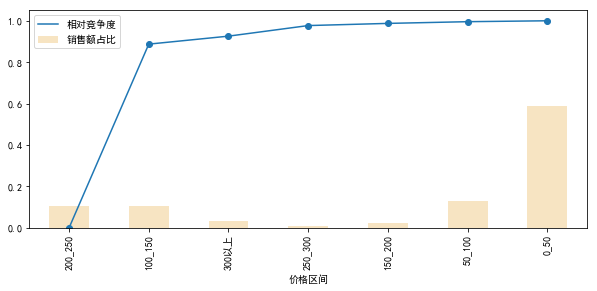

In [57]:
draw_plot(byprice)

### 灭鼠0_50价格区间细分价格分析

- 选择灭鼠数据价格区间在0_50的记录

In [58]:
df50 = df25[df25['价格区间']=='0_50']

- 切分数据

In [59]:
bins2 = [0,10,20,30,40,50]
labels2 = ['0_10','10_20','20_30','30_40','40_50']
df50['价格子区间'] = pd.cut(df50['售价'],bins=bins2,labels=labels2,include_lowest=True)

E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [60]:
df50.head()

,类别,宝贝ID,销量（人数）,售价,预估销售额,评价人数,收藏人数,地域,店铺类型,品牌,型号,净含量,适用对象,物理形态,价格区间,价格子区间
2000,灭鼠,566054780243,9976,26.8,267356.8,11901.0,11596,广东 韶关,天猫,优璇福,MT007,NaN,老鼠,胶水,0_50,20_30
2001,灭鼠,566054780243,9976,26.8,267356.8,NaN,11596,广东 深圳,天猫,优璇福,MT007,NaN,老鼠,胶水,0_50,20_30
2002,灭鼠,572115448996,9945,9.9,98455.5,26442.0,3569,NaN,淘宝,创驰,21/32,NaN,老鼠,固体,0_50,0_10
2003,灭鼠,39868408322,99,29.9,2960.1,20.0,352,河南 南阳,天猫,云杀,粘鼠板,NaN,老鼠,固体,0_50,20_30
2004,灭鼠,520282897220,99,39.9,3950.1,559.0,1250,NaN,淘宝,得硕,NaN,g,老鼠,固体,0_50,30_40


In [61]:
byprice2 = by_fun(df50,'价格子区间')
byprice2

,预估销售额,销售额占比,宝贝数,宝贝数占比,单宝贝平均销售额,相对竞争度
价格子区间,,,,,,
10_20,8102634.14,0.534401,272,0.318501,29789.096103,0.000000
20_30,4969620.92,0.327766,278,0.325527,17876.334245,0.411674
40_50,707568.49,0.046667,40,0.046838,17689.212250,0.418141
30_40,1240874.19,0.081841,98,0.114754,12661.981531,0.591869
0_10,141388.77,0.009325,166,0.194379,851.739578,1.000000


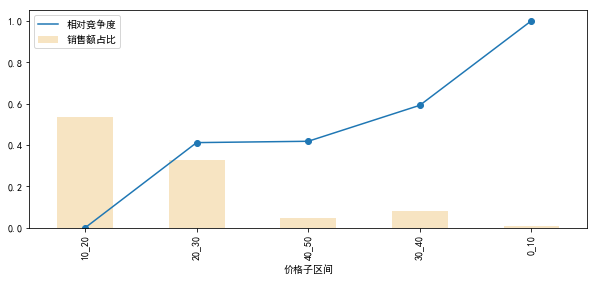

In [62]:
draw_plot(byprice2)

- 对灭鼠0_50价格区间，根据“店铺类型”分组

In [63]:
bystore = by_fun(df50,'店铺类型')
bystore

,预估销售额,销售额占比,宝贝数,宝贝数占比,单宝贝平均销售额,相对竞争度
店铺类型,,,,,,
天猫,14019740.58,0.924658,220,0.257611,63726.093545,0.0
淘宝,1142345.93,0.075342,634,0.742389,1801.807461,1.0


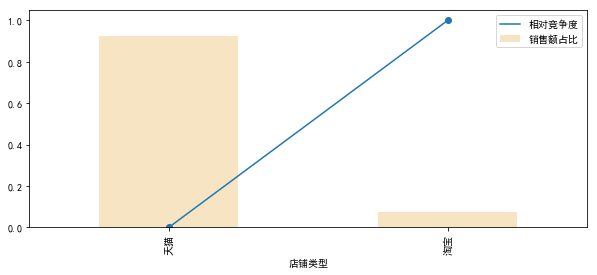

In [64]:
draw_plot(bystore)

- 选取预估销售额排名前5%的型号，并通过这些型号分组，制图

In [65]:
byshape = by_fun(df50,'型号',sort='预估销售额')
df95 = byshape[byshape['预估销售额']>byshape['预估销售额'].quantile(0.95)]
df95

,预估销售额,销售额占比,宝贝数,宝贝数占比,单宝贝平均销售额,相对竞争度
型号,,,,,,
超强力粘鼠板,2120129.32,0.142219,12,0.021661,176677.443333,0.669585
粘鼠板老鼠贴,2051699.02,0.137629,7,0.012635,293099.860000,0.451856
0005,927590.70,0.062223,2,0.003610,463795.350000,0.132628
驰天粘鼠板,876606.33,0.058803,4,0.007220,219151.582500,0.590151
QL-866,759629.30,0.050956,3,0.005415,253209.766667,0.526457
MT007,534713.60,0.035869,1,0.001805,534713.600000,0.000000
强力粘鼠魔毯,496974.60,0.033337,1,0.001805,496974.600000,0.070578
拜灭士5g,420982.40,0.028240,1,0.001805,420982.400000,0.212696
CQL-1,391271.40,0.026247,1,0.001805,391271.400000,0.268260


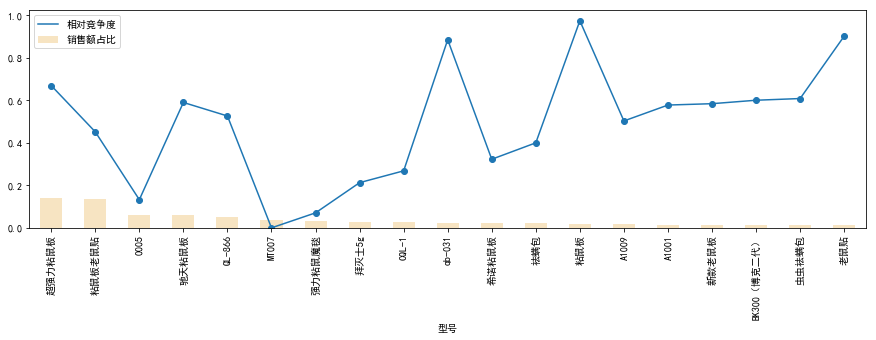

In [66]:
draw_plot(df95,figsize=(15,4))

- 按照“物理形态”分组，并制图

In [67]:
byphysical = by_fun(df50,'物理形态')

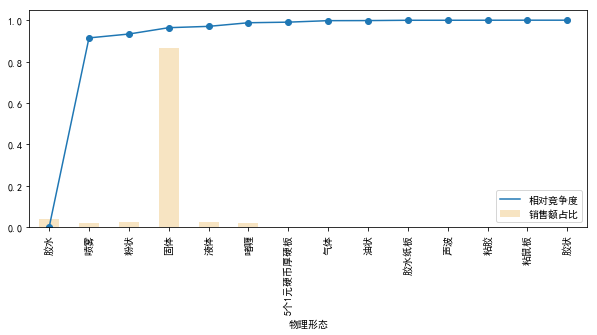

In [68]:
draw_plot(byphysical)

- 通过“物理形态”和“净含量”共同分组，并按照“物理形态”和“预估销售额”排序

In [69]:
bycommon = by_fun(df50,['物理形态','净含量'],sort=['物理形态','预估销售额'])

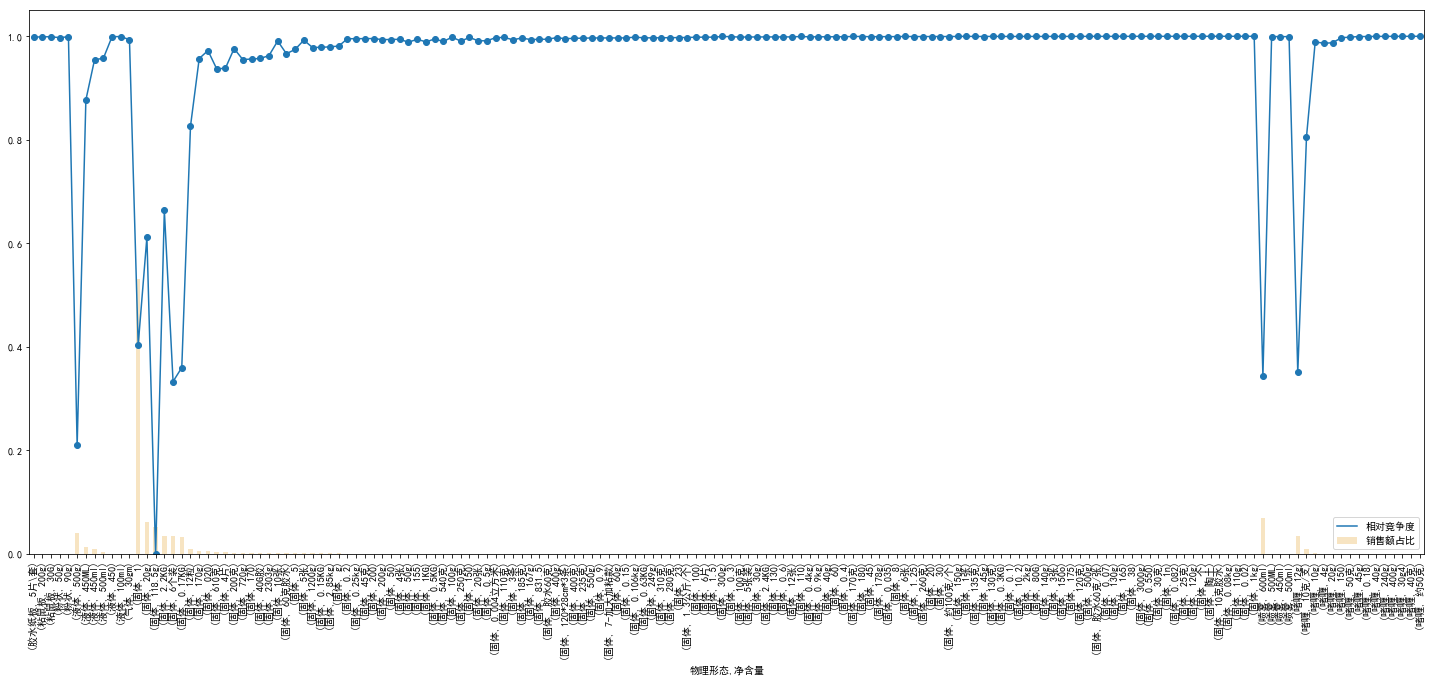

In [70]:
draw_plot(bycommon,figsize=(25,10))

## 竞争分析——商品销售数据

In [71]:
os.chdir(r'E:\千锋上海\data\竞争数据\商品销售数据')  # 切换目录

In [72]:
filenames2 = glob.glob("*.xlsx")
filenames2

['安速家居近30天销售数据.xlsx', '拜耳近30天销售数据.xlsx', '科凌虫控旗舰店近30天销售数据.xlsx']

- 编写函数读取销售数据，并进行数据清洗

In [73]:
def read_sale_excel(filename):
    df = pd.read_excel(filename)
    useless = ['序号','店铺名称','商品名称','主图链接','商品链接']
    df.drop(columns=useless,inplace=True)
    return df

In [74]:
# 分别读取文件，转换成DataFrame对象
sale_list = [read_sale_excel(filename) for filename in filenames2]
dfbai_sale = sale_list[1]
dfan_sale = sale_list[0]
dfke_sale = sale_list[2]

In [75]:
# 通过类目分别对三个DataFrame分组
dfbai_category = dfbai_sale.groupby('类目').sum()
dfan_category = dfan_sale.groupby('类目').sum()
dfke_category = dfke_sale.groupby('类目').sum()

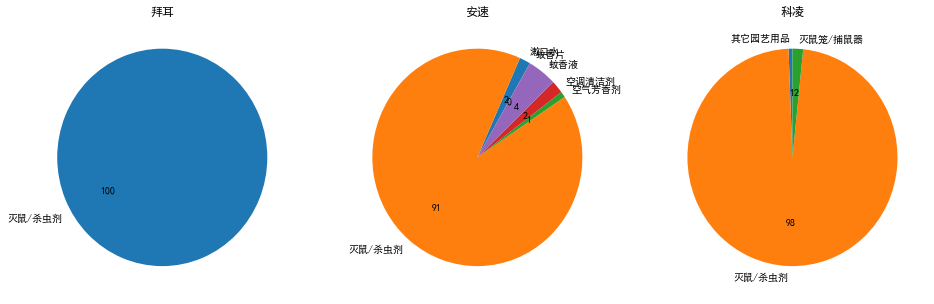

In [76]:
# 绘图分析各家商户的产品类目的分布
fig,axes = plt.subplots(1,3,figsize=(16,5))  # 规划子图，返回两个对象，分别代表图像和绘图区域数组
ax = axes[0]  # 选择第一个绘图区域
dfbai_category["销售额"].plot.pie(autopct='%.f',title='拜耳',ax=ax,startangle=30)
ax.set_ylabel("")
ax = axes[1]  # 选择第二个绘图区域
dfan_category["30天销售额"].plot.pie(autopct='%.f',title='安速',ax=ax,startangle=60)
ax.set_ylabel("")
ax = axes[2]  # 选择第三个绘图区域
dfke_category["30天销售额"].plot.pie(autopct='%.f',title='科凌',ax=ax,startangle=90)
ax.set_ylabel("")
plt.show()

- 通过适用对象分别对三个DataFrame分组

In [77]:
dfbai_use = dfbai_sale.groupby('使用对象').sum()
dfan_use = dfan_sale.groupby('适用对象').sum()
dfke_use = dfke_sale.groupby('适用对象').sum()

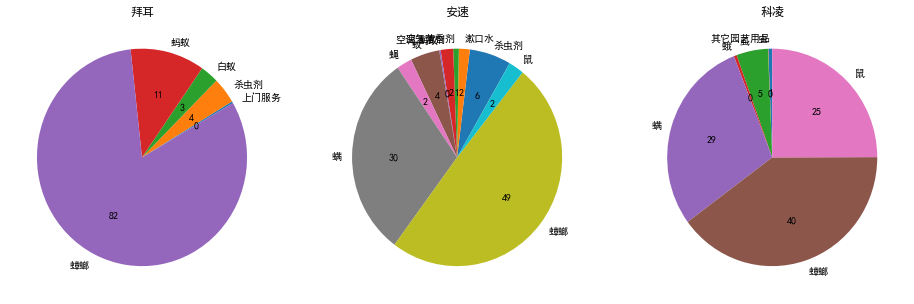

In [78]:
# 绘图分析各家商户的产品适用对象的分布
fig,axes = plt.subplots(1,3,figsize=(16,5))  # 规划子图，返回两个对象，分别代表图像和绘图区域数组
ax = axes[0]  # 选择第一个绘图区域
dfbai_use["销售额"].plot.pie(autopct='%.f',title='拜耳',ax=ax,startangle=30)
ax.set_ylabel("")
ax = axes[1]  # 选择第二个绘图区域
dfan_use["30天销售额"].plot.pie(autopct='%.f',title='安速',ax=ax,startangle=60)
ax.set_ylabel("")
ax = axes[2]  # 选择第三个绘图区域
dfke_use["30天销售额"].plot.pie(autopct='%.f',title='科凌',ax=ax,startangle=90)
ax.set_ylabel("")
plt.show()

## 竞争分析——商品交易数据

In [79]:
os.chdir('E:\千锋上海\data\竞争数据\商品交易数据')  # 切换目录

In [80]:
filenames3 = glob.glob("*.xlsx")
filenames3

['安速全店商品交易数据.xlsx', '拜耳全店商品交易数据.xlsx', '科凌虫控全店商品交易数据.xlsx']

### 拜耳交易数据分析

In [81]:
dfbai_tran = pd.read_excel(filenames3[1])  # 读取拜耳交易数据

- 自定义分类汇总函数,按照“商品”分组

In [82]:
def by_product(df):
    df_pro = df.groupby('商品').mean().loc[:,['交易增长幅度']]  # 计算每组的平均“交易增长幅度”
    df_pro['交易金额'] = df.groupby('商品').sum()['交易金额']
    df_pro['交易金额占比'] = df_pro['交易金额'] / df_pro['交易金额'].sum()
    df_pro['商品个数'] = df.groupby('商品').count()['交易金额']
    df_pro.reset_index(inplace=True)
    return df_pro 

In [83]:
dfbai_product = by_product(dfbai_tran)
dfbai_product.head()

,商品,交易增长幅度,交易金额,交易金额占比,商品个数
0,17年德国拜耳进口蚂蚁药拜灭易灭蚁饵剂粉除杀蚂蚁杀虫剂全窝端,-0.247600,42340.55,0.000523,1
1,德国原装进口拜耳蟑螂药全窝端拜灭士5g+12g杀蟑胶饵剂粉屋捕捉器,-0.120333,197377.17,0.002439,3
2,德国拜耳 除敌跳蚤杀虫剂家用灭蟑螂药虱子杀潮虫臭虫除虫剂喷雾,-0.221080,1394780.59,0.017232,5
3,德国拜耳丁香医生限量款拜灭士加量家用蟑螂全窝端蟑螂药3支装,1.279300,26742.75,0.000330,1
4,德国拜耳上门除灭鼠灭白蚁蟑螂蚊子跳蚤苍蝇上海地区灭虫按件拍下,2.439300,28969.28,0.000358,1


- 描述分组之后的DataFrame

In [84]:
dfbai_product.describe()

,交易增长幅度,交易金额,交易金额占比,商品个数
count,44.000000,4.400000e+01,44.000000,44.000000
mean,25.539933,1.839560e+06,0.022727,3.227273
std,155.083825,6.321050e+06,0.078095,1.668639
min,-0.292100,2.255362e+04,0.000279,1.000000
25%,-0.061040,6.828508e+04,0.000844,1.750000
50%,0.109000,2.061879e+05,0.002547,3.000000
75%,1.287410,7.673291e+05,0.009480,5.000000
max,1030.000000,4.010385e+07,0.495473,5.000000


- 实现盖帽法函数

In [85]:
def block(ser):
    qu = ser.quantile(0.9)  
    out = ser.mask(ser>qu,qu)
    return out

In [86]:
def block_df(df):
    dfb = df.copy()
    dfb['交易增长幅度'] = block(dfb['交易增长幅度'])
    dfb['交易金额占比'] = block(dfb['交易金额占比'])
    return dfb

In [87]:
dfbai_block = block_df(dfbai_product)
dfbai_block.describe()

,交易增长幅度,交易金额,交易金额占比,商品个数
count,44.000000,4.400000e+01,44.000000,44.000000
mean,1.171668,1.839560e+06,0.007699,3.227273
std,2.212537,6.321050e+06,0.010333,1.668639
min,-0.292100,2.255362e+04,0.000279,1.000000
25%,-0.061040,6.828508e+04,0.000844,1.750000
50%,0.109000,2.061879e+05,0.002547,3.000000
75%,1.287410,7.673291e+05,0.009480,5.000000
max,6.717030,4.010385e+07,0.031863,5.000000


In [88]:
def plotBCG(df,mean=False,q1=0.5,q2=0.5):
    plt.subplots(figsize=(10,8))  
    # hue参数：使用不同颜色对各组的数据加以区分
    ax = sns.scatterplot('交易金额占比','交易增长幅度',
                         hue='商品个数',size='商品个数',sizes=(20,200),
                         palette = 'cool',legend='full',data=df)
    for i in range(0,len(df)):
        ax.text(df['交易金额占比'][i]+0.001,df['交易增长幅度'][i],i)
    if mean:
        plt.axvline(df['交易金额占比'].mean())
        plt.axhline(df['交易增长幅度'].mean())
    else:
        plt.axvline(df['交易金额占比'].quantile(q1))
        plt.axhline(df['交易增长幅度'].quantile(q2))
    plt.show()

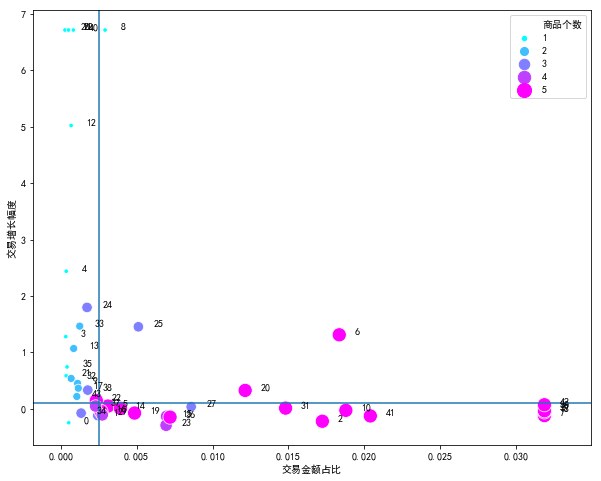

In [89]:
# 绘制波士顿矩阵，以坐标轴的中位数作为矩阵的分割线
plotBCG(dfbai_block)

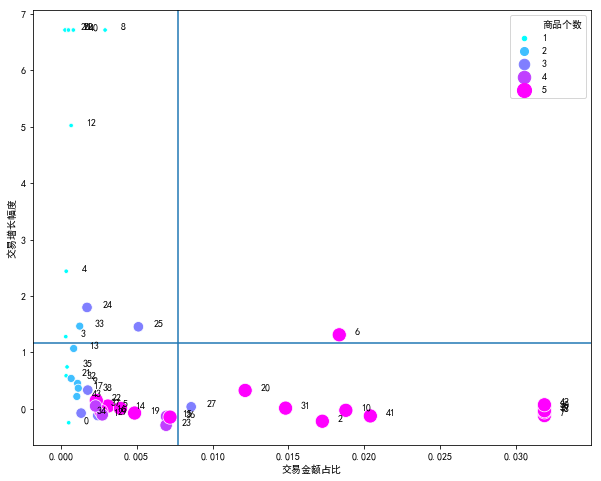

In [90]:
# 以平均值作为矩阵分隔线
plotBCG(dfbai_block,mean=True)

- 自定义区分产品结构函数

In [91]:
def extractBCG(df,q1=0.5,q2=0.5,by='交易金额占比'):
    star = df.loc[(df['交易金额占比']>=df['交易金额占比'].quantile(q1))
                  &(df['交易增长幅度']>=df['交易增长幅度'].quantile(q2)),:]
    star = star.sort_values(by,ascending=False)
    cow = df.loc[(df['交易金额占比']>=df['交易金额占比'].quantile(q1))
                  &(df['交易增长幅度']<df['交易增长幅度'].quantile(q2)),:]
    cow = cow.sort_values(by,ascending=False)
    que = df.loc[(df['交易金额占比']<df['交易金额占比'].quantile(q1))
                  &(df['交易增长幅度']>=df['交易增长幅度'].quantile(q2)),:]
    que = que.sort_values(by,ascending=False)
    return star,cow,que

In [92]:
baistar,baicow,baique = extractBCG(dfbai_product)
baistar1,baicow1,baique1 = extractBCG(dfbai_product,by='交易增长幅度')

In [93]:
baistar  # 拜耳明星产品

,商品,交易增长幅度,交易金额,交易金额占比,商品个数
6,德国拜耳拜灭士5g+除敌5ml*4支进口蟑螂药家用全窝端杀蟑螂套装,1.311740,1484952.41,0.018346,5
20,德国拜耳除敌杀虫剂灭蟑螂药跳蚤苍蝇臭虫除螨虱子喷雾5ml*8,0.325580,983199.69,0.012147,5
25,拜耳拜灭士 蟑螂药家用全窝端 强力灭除厨房蟑螂屋克星杀德国进口,1.454067,413902.42,0.005114,3
8,德国拜耳拜灭士蟑螂药一窝端进口全窝端家用灭除杀蟑胶饵5g包邮,29.260600,236386.32,0.002920,1


In [94]:
baicow  # 拜耳奶牛产品

,商品,交易增长幅度,交易金额,交易金额占比,商品个数
7,德国拜耳拜灭士蟑螂药一窝端杀蟑胶饵灭蟑螂屋无毒克星家用全窝端,-0.121360,40103850.97,0.495473,5
39,进口蟑螂药一窝端德国拜耳拜灭士强力杀蟑胶饵蟑螂屋克星家用全窝,-0.034680,13617307.87,0.168238,5
18,德国拜耳进口蚂蚁药拜灭易灭蚁饵剂除杀蚂蚁杀虫剂家用室内全窝端,-0.056240,6130488.42,0.075741,5
42,进口蟑螂药德国拜耳拜灭士灭杀蟑胶饵剂粉屋克星全窝端12g家用,0.070960,3589799.54,0.044351,5
30,蟑螂药一窝端德国拜耳拜灭士除蟑灭杀蟑螂克星全窝端家用杀蟑胶,0.038900,2976922.63,0.036779,5
41,进口蟑螂药德国拜耳拜灭士杀蟑胶饵蟑螂克星全窝端家用灭蟑屋12g,-0.127140,1650681.34,0.020394,5
10,德国拜耳拜灭易灭蚁饵剂粉除杀防蚂蚁药杀虫剂全窝端家用室内花园,-0.027300,1520126.15,0.018781,5
2,德国拜耳 除敌跳蚤杀虫剂家用灭蟑螂药虱子杀潮虫臭虫除虫剂喷雾,-0.221080,1394780.59,0.017232,5
31,蟑螂药德国拜耳拜灭士强力除杀蟑螂克星胶饵屋家用捕捉器贴全窝端,0.011680,1198694.67,0.014810,5
27,拜耳蟑螂药一窝端家用拜灭士杀蟑胶饵德国小强药粉灭蟑螂厨房克星,0.035400,695372.27,0.008591,3


In [95]:
baique

,商品,交易增长幅度,交易金额,交易金额占比,商品个数
22,德国进口拜耳蟑螂药拜灭士杀蟑胶饵5g两盒套装全窝端杀灭蟑螂剂屋,0.147040,189376.20,0.002340,5
38,进口蟑螂药 德国拜耳拜灭士杀蟑螂胶饵剂33克灭蟑螂药全窝端家用,0.331367,143883.32,0.001778,3
24,拜灭士蟑螂药蟑螂克星家用无毒强力灭蟑清德国拜耳杀蟑饵剂全窝端,1.797267,140032.47,0.001730,3
33,蟑螂药进口德国拜耳拜灭士家用除杀蟑螂屋胶饵捕捉器强力清全窝端,1.465350,101079.33,0.001249,2
17,德国拜耳进口蚂蚁药拜灭易灭蚁饵剂除杀蚂蚁无毒家用室内全窝端,0.364950,93400.98,0.001154,2
9,德国拜耳拜灭易12g+除敌5ml*4支 进口蚂蚁药全窝端家用杀虫剂组合,0.450550,89566.01,0.001107,2
43,预售德国拜耳进口蟑螂药进口蚂蚁药组合装5g+12g,0.218150,85546.09,0.001057,2
13,德国拜耳蟑螂药拜灭士杀蟑胶饵蟑螂克星全窝端家用灭蟑加量装12g,1.069050,68699.06,0.000849,2
40,进口蟑螂药一窝端德国拜耳拜灭士杀蟑胶饵诱防蟑螂屋全窝端5+12g,31.218500,67043.14,0.000828,1
32,蟑螂药拜耳拜灭士杀蟑胶饵强力灭蟑清贴捕捉器蟑螂克星家用全窝端,0.538100,55395.16,0.000684,2


In [96]:
baique1

,商品,交易增长幅度,交易金额,交易金额占比,商品个数
28,电子猫超声波驱鼠器家用大功率灭鼠防鼠赶老鼠夹药捕鼠干扰粘鼠板,1030.000000,41046.03,0.000507,1
40,进口蟑螂药一窝端德国拜耳拜灭士杀蟑胶饵诱防蟑螂屋全窝端5+12g,31.218500,67043.14,0.000828,1
11,德国拜耳拜灭易进口蚂蚁药一窝端灭蚁饵剂清除蚂蚁粉家用全窝端,7.867000,32246.39,0.000398,1
26,拜耳灭蚂蚁药家用一窝端室内室外用杀小黄红蚂蚁药神器胶饵拜灭易,7.442700,22553.62,0.000279,1
12,德国拜耳白蚁药杀虫剂全窝端家用除杀防治灭飞蚂蚁特密得预防装修,5.023800,55113.41,0.000681,1
4,德国拜耳上门除灭鼠灭白蚁蟑螂蚊子跳蚤苍蝇上海地区灭虫按件拍下,2.439300,28969.28,0.000358,1
24,拜灭士蟑螂药蟑螂克星家用无毒强力灭蟑清德国拜耳杀蟑饵剂全窝端,1.797267,140032.47,0.001730,3
33,蟑螂药进口德国拜耳拜灭士家用除杀蟑螂屋胶饵捕捉器强力清全窝端,1.465350,101079.33,0.001249,2
3,德国拜耳丁香医生限量款拜灭士加量家用蟑螂全窝端蟑螂药3支装,1.279300,26742.75,0.000330,1
13,德国拜耳蟑螂药拜灭士杀蟑胶饵蟑螂克星全窝端家用灭蟑加量装12g,1.069050,68699.06,0.000849,2


### 安速交易数据分析

In [97]:
# 读取安速交易的excel数据文件
dfan_tran = pd.read_excel(filenames3[0])

In [98]:
# 调用分类汇总函数，根据商品分类
dfan_product = by_product(dfan_tran)

In [99]:
# 盖帽
dfan_block = block_df(dfan_product)

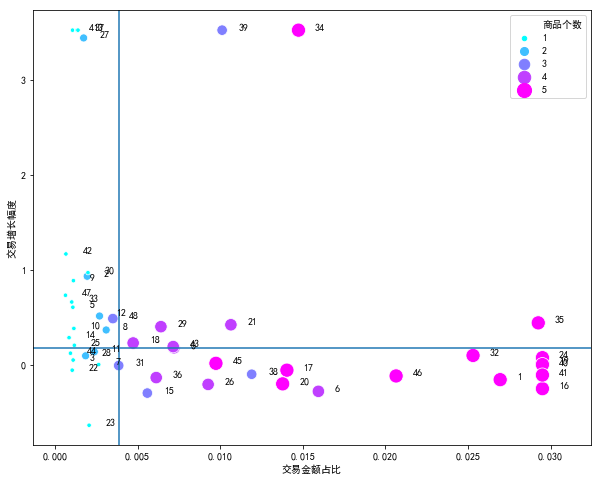

In [100]:
# 绘制安速的波士顿矩阵
plotBCG(dfan_block)

In [101]:
anstar,ancow,anque = extractBCG(dfan_product)
anstar1,ancow1,anque1 = extractBCG(dfan_product,by='交易增长幅度')

In [102]:
anstar

,商品,交易增长幅度,交易金额,交易金额占比,商品个数
35,日本安速蟑螂小屋灭除杀蟑螂药一窝端神器捕捉器家用克星小强恢恢,0.440000,881587.79,0.029254,5
34,日本安速蚂蚁药灭蚂蚁清驱除杀红蚂蚁小黄蚂蚁全窝端家用室内花园,21.464140,444230.43,0.014741,5
21,日本安速小黑帽小强黑克杀蟑饵剂9枚 蟑螂药屋蟑螂克星家用全窝端,0.419900,320927.90,0.010649,4
39,日本进口安速天然除螨喷雾剂350ml床上免洗家用正品螨虫非除杀菌,3.859333,304915.11,0.010118,3
0,10枚装日本进口安速小强恢恢蟑螂屋诱捕捉器杀药贴环保无毒包邮,0.176750,217061.51,0.007203,4
43,日本进口安速小强恢恢蟑螂屋5片药捕捉器灭杀蟑螂克星家用全窝端,0.189600,215689.30,0.007157,4
29,日本安速红阿斯杀虫烟雾剂20g弹烟熏灭跳蚤蟑螂药克星家用全窝端,0.399800,193282.28,0.006414,4
18,日本安速小强恢恢蟑螂屋灭蟑螂强力捕捉器诱捕器除杀蟑螂清药贴,0.227425,142604.89,0.004732,4


In [103]:
ancow

,商品,交易增长幅度,交易金额,交易金额占比,商品个数
19,日本安速小强恢恢蟑螂屋纸盒子捕捉器药灭杀强力家用贴克星全窝端,0.012180,13294975.97,0.441164,5
41,日本进口安速小强恢恢灭蟑螂屋药无毒捕捉器克星家用强力清全窝端,-0.111000,3685204.19,0.122285,5
40,日本进口安速小强恢恢杀蟑灭蟑螂屋10枚捕捉器不含蟑螂药,-0.000740,2354769.41,0.078138,5
24,日本安速小黑帽蟑螂屋家用强力灭蟑螂药环保无毒无味除小强包邮,0.072400,1083611.82,0.035957,5
16,日本安速小强恢恢蟑螂屋家用杀蟑胶饵小蟑螂药无毒蟑螂克星全窝端,-0.254840,919683.22,0.030518,5
1,✅【10枚装】日本进口安速小强恢恢蟑螂屋捕捉器杀药贴家用全窝端,-0.159780,812113.82,0.026948,5
32,日本安速红阿斯烟雾杀虫剂灭跳蚤药烟弹家用神器螨虫克星送蟑螂屋,0.095920,762628.32,0.025306,5
46,日本进口安速红阿斯杀虫烟雾剂弹烟熏灭跳蚤蟑螂克星家用全窝端,-0.120460,622279.57,0.020649,5
6,原装进口日本安速红阿斯杀虫烟雾剂熏杀灭跳蚤臭虫螨虫蟑螂20克,-0.283000,480525.86,0.015945,4
17,日本安速小强恢恢蟑螂屋捕捉器神器厨房清灭强力贴克星家用全窝端,-0.059500,423102.79,0.014040,5


In [104]:
anque1

,商品,交易增长幅度,交易金额,交易金额占比,商品个数
4,冲销量日本安速小黑帽蟑螂屋蟑螂药家用强力灭蟑清安全无毒小强,42.01430,32034.34,0.001063,1
37,日本安速除螨虫喷雾剂床上免洗去螨虫神器喷剂家用非杀菌送除螨包,6.64800,41991.71,0.001393,1
13,日本安速ARS地球制药earth小飞虫恢恢果蝇诱捕器单只装 0315,4.36430,40441.40,0.001342,1
27,日本安速杀蟑气雾剂精纯无味型2瓶 灭蟑螂药杀虫剂家用潮虫百虫灵,3.44830,52292.37,0.001735,2
42,日本进口安速小强恢恢蟑螂屋5片家用无毒贴捕捉器克星家用全窝端,1.16750,19943.68,0.000662,1
30,日本安速红阿斯杀虫烟雾剂弹10g烟熏灭跳蚤蟑螂克星家用全窝端,0.97050,60200.62,0.001998,1
2,【20枚装】日本进口安速小强恢恢蟑螂屋蟑螂捕捉器诱捕器灭蟑小屋,0.93215,58785.41,0.001951,2
9,日本 安速EARTH小果蝇恢恢杀蝇饵剂灭苍蝇小飞虫神器诱捕捕捉器,0.88560,33633.57,0.001116,1
47,日本进口安速红阿斯杀虫烟雾剂跳蚤螨虫蚂蚁药蟑螂克星家用全窝端,0.73170,19166.12,0.000636,1
33,日本安速老鼠吱吱板4片 老鼠贴强力粘鼠板驱鼠灭鼠器老鼠胶药家用,0.66030,30567.08,0.001014,1


### 科凌交易数据分析

In [105]:
dfke_tran = pd.read_excel(filenames3[2])

In [106]:
dfke_product = by_product(dfke_tran)

In [107]:
dfke_block = block_df(dfke_product)

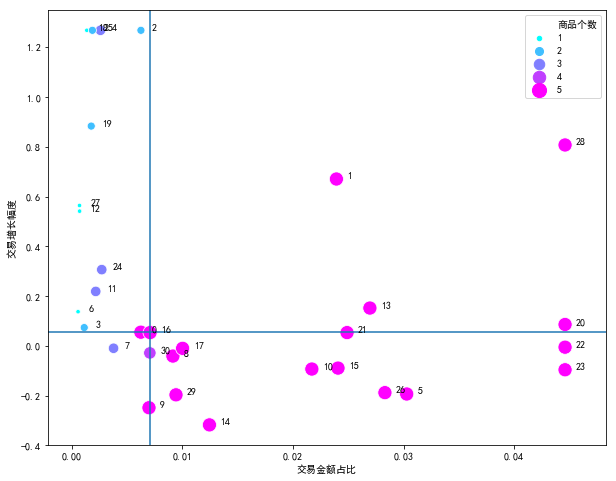

In [108]:
plotBCG(dfke_block)

In [109]:
kestar,kecow,keque = extractBCG(dfke_product)
kestar1,kecow1,keque1 = extractBCG(dfke_product,by='交易增长幅度')

In [110]:
kestar

,商品,交易增长幅度,交易金额,交易金额占比,商品个数
28,除螨虫家用喷剂床上祛防螨去螨虫神器喷雾剂包贴杀虫剂免洗非杀菌,0.80742,2270518.54,0.048815,5
20,老鼠贴超强力粘鼠板灭鼠神器捕鼠魔毯yao颗粒老鼠胶家用药捕鼠器,0.08576,2074886.77,0.044609,5
13,科凌虫控蟑螂药屋蟑螂克星杀蟑胶饵灭蟑螂粉全窝端家用强力灭蟑清,0.15184,1253677.00,0.026953,5
1,去儿童头虱除阴虱净喷剂百部酊虱卵用虱子药成人一扫光净虱灵喷雾,0.67058,1112790.54,0.023924,5


In [111]:
kecow

,商品,交易增长幅度,交易金额,交易金额占比,商品个数
23,蟑螂药一窝端蟑螂屋胶饵灭蟑螂无毒厨房家用强力杀蟑螂克星全窝端,-0.09628,21966057.02,0.472259,5
22,蟑螂屋捕捉器除灭蟑螂药一窝端神器纸盒子胶饵杀小蟑螂贴厨房家用,-0.00548,7464346.74,0.160480,5
5,杀蟑螂药一窝端蟑螂药粉家用捕捉器屋厨贴无毒灭蟑螂粉除小强克星,-0.19370,1408637.81,0.030285,5
26,跳蚤杀虫剂家用厕所卫生间下水道除虫灭小飞虫蛾蚋蟑螂臭虫药室内,-0.18824,1316871.08,0.028312,5
21,蟑螂屋强力灭蟑清蟑螂贴家用无毒粉杀蟑螂药胶饵捕捉器克星全窝端,0.05320,1157585.18,0.024888,5
15,粘鼠板超强力驱老鼠贴灭鼠抓老鼠夹药捕鼠器黏老鼠胶沾鼠神器家用,-0.08956,1119499.65,0.024069,5
10,科凌虫控杀蟑螂药一窝端灭蟑螂胶饵药粉克星南方大蟑螂全窝端家用,-0.09338,1009419.11,0.021702,5
14,米面蛾诱捕器蛾子粘捕器家用小飞虫杀虫剂灭飞蛾除米蛾衣蛾蚋蛾蠓,-0.31784,578549.20,0.012439,5
17,老鼠笼捕鼠器全自动超强家用抓老鼠夹药捉耗子连续灭鼠神器驱鼠器,-0.01008,465621.51,0.010011,5
29,除跳蚤喷剂床上杀虫剂气雾家用潮虫驱虫灭去蚂蚁药神器室内杀蜘蛛,-0.19702,437756.89,0.009412,5


In [112]:
keque1

,商品,交易增长幅度,交易金额,交易金额占比,商品个数
2,天然除螨虫包喷雾剂中草药祛防杀去螨虫垫贴床上用品家用驱虫神器,407.98265,290170.09,0.006239,2
4,抓老鼠贴强力粘鼠板胶药沾灭鼠器捕鼠神器克星家用正品20张一窝端,4.21950,119948.74,0.002579,3
18,老鼠笼捕鼠器家用一窝端连续全自动强力扑捉抓灭老鼠夹子捕鼠神器,1.31100,62508.93,0.001344,1
25,蟑螂药蟑螂克星家用非无毒全窝端室内厨房南方大蟑螂一窝端脏螂药,1.26835,86020.53,0.001849,2
19,老鼠贴强力粘鼠板正品一窝端灭鼠器老鼠克星胶yao颗粒家用10片装,0.88335,81123.80,0.001744,2
27,跳蚤杀虫剂家用气雾剂除螨虫喷雾潮虫百虫灵蜈蚣蟑螂药灭蚂蚁虱子,0.56420,31783.47,0.000683,1
12,科凌虫控蟑螂药南方大蟑螂强力杀蟑饵剂蟑螂胶饵家用全窝端灭蟑清,0.54140,32057.62,0.000689,1
24,蟑螂药粉德国小蠊小强专杀灭蟑螂屋纸盒子家用蟑螂克星全窝端厨房,0.30630,125300.73,0.002694,3
11,科凌虫控老鼠贴超强力粘鼠板日本版捉抓老鼠夹胶家用灭鼠药捕鼠器,0.21870,99998.35,0.002150,3
6,汽车家用驱鼠剂防老鼠克星喷雾剂耗子发动机舱包防鼠灭鼠药驱鼠器,0.13730,25665.98,0.000552,1


## 流量渠道分析

In [113]:
# 切换目录
os.chdir('E:\千锋上海\data\竞争数据\流量渠道数据')

In [114]:
# 读取该目录下的Excel文件
filenames4 = glob.glob("*.xlsx")
filenames4

['安速家居旗舰店流量渠道.xlsx', '拜耳官方旗舰店流量渠道.xlsx', '科凌虫控旗舰店流量渠道.xlsx']

### 拜耳流量渠道分析

In [115]:
# 读取拜耳流量文件数据
dfbai_excel = pd.read_excel(filenames4[1])

In [116]:
dfbai_excel.head()

,流量来源,交易指数,交易指数.1
0,淘内免费,399466,320128
1,手淘搜索,336457,274916
2,淘内免费其他,195308,153255
3,手淘问大家,123512,108108
4,手淘旺信,88024,59198


- 流量分析函数

In [117]:
def flow(df):
    df_copy = df.copy()
    df_top10 = df_copy.sort_values('交易指数',ascending=False).reset_index(drop=True).iloc[:10,:]
    df_top10['交易指数占比'] = df_top10['交易指数'] / df_top10['交易指数'].sum()
    df_top10.set_index('流量来源',inplace=True)
    return df_top10

In [118]:
df_top10 = flow(dfbai_excel)

- 绘图并输出解释饼图的文字

In [119]:
def draw_flow(df):
    paid =  ['付费流量','直通车','淘宝客','淘宝联盟']
    # 获取需要付费的流量对应的布尔值（需要付费的流量行对应True）
    ind = np.array([True if name in paid else False for name in df.index])
    explode = ind * 0.1
    ax = df['交易指数占比'].plot.pie(autopct='%.1f%%',figsize=(8,8),colormap='cool',
                              explode=explode)
    ax.set_ylabel('')
    plt.show()

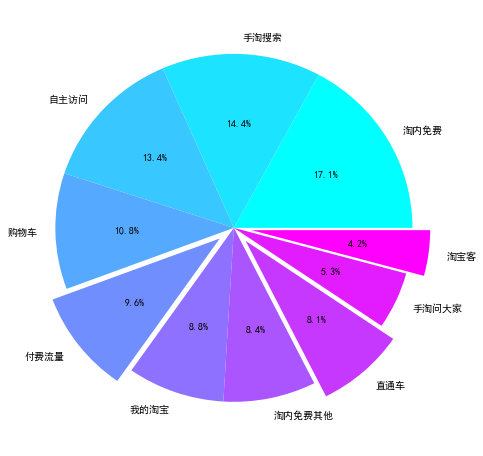

In [120]:
draw_flow(df_top10)

### 安速流量渠道分析

In [121]:
# 读取安速流量文件数据
dfan_excel = pd.read_excel(filenames4[0])
dfan_excel.head()

,流量来源,交易指数
0,淘内免费,119751
1,手淘搜索,86389
2,淘内免费其他,62653
3,手淘问大家,31348
4,手淘旺信,25514


In [122]:
dfan_top10 = flow(dfan_excel)

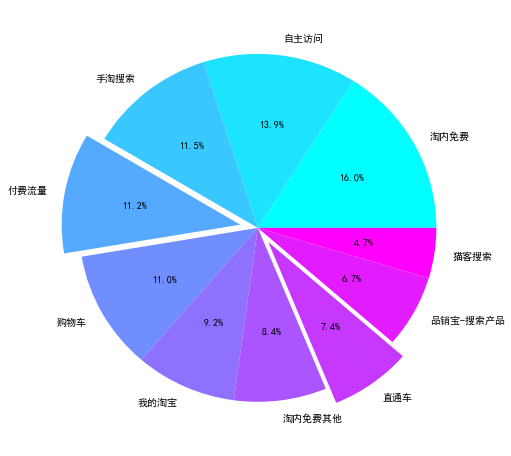

In [123]:
draw_flow(dfan_top10)

### 科凌流量渠道分析

In [124]:
# 读取科凌流量文件数据
dfke_excel = pd.read_excel(filenames4[2])
dfke_excel.head()

,流量来源,交易指数
0,淘内免费,320128
1,手淘搜索,274916
2,淘内免费其他,153255
3,手淘问大家,108108
4,手淘旺信,59198


In [125]:
dfke_top10 = flow(dfke_excel)

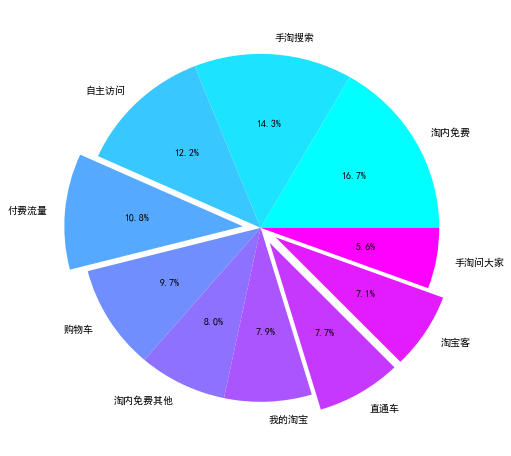

In [126]:
draw_flow(dfke_top10)

# 舆情分析

In [127]:
# 切换目录
os.chdir('E:\千锋上海\data\竞争数据\评论舆情数据')

In [128]:
filenames5 = glob.glob("*.xlsx")
filenames5

['安速.xlsx', '德国拜耳.xlsx', '科林虫控.xlsx']

### 拜耳舆情分析

In [129]:
dfbai_yu = pd.read_excel(filenames5[1])  # 读取拜耳舆情excel
comment_list = list(dfbai_yu['评论'])  # 抽取评论列，并转化为list

- 去掉评论列表里非中英文字符

In [130]:
comment_list2 = [re.sub(r'[^a-zA-Z\u4E00-\u9Fa5]+',' ',comment) for comment in comment_list]

In [131]:
# re.sub()举例用法
re.sub(r'\d+','好','abc123def456xyz')

'abc好def好xyz'

- 读取构建停用词列表

In [132]:
stopwords = list(pd.read_csv('E:\千锋上海\data\百度停用词表.txt',
            engine='python',encoding='utf-8',
           names=['stopwords'])['stopwords'])


In [138]:
import jieba
results = []
for comment in comment_list2:  # 遍历评论列表
    wordlist = jieba.lcut(comment)  # 对每条评论进行中文文本分词
    ser1 = pd.Series(wordlist)
    ind = pd.Series([len(word)>1 for word in wordlist]) 
    ser2 = ser1[ind]  # 淘汰掉了长度为1的分词
    ind2 = ~ser2.isin(stopwords)  # 获取是否出现在停用词列表的索引（取反）
    ser3 = ser2[ind2].unique()  # 淘汰掉了停用词列表中的词语,并去掉重复分词
    if len(ser3) > 0:
        results.append(list(ser3))

In [139]:
results[:2]  # 去前两条评论的分词结果

[['收到',
  '家里',
  '厨房',
  '小强',
  '评价',
  '销量',
  '赶紧',
  '三盒',
  '管用',
  '后续',
  '效果',
  '追加',
  '多久',
  '才能',
  '消灭',
  '干净',
  '没法',
  '做饭',
  '进去',
  '担心',
  '挥发',
  '很多',
  '试试'],
 ['朋友',
  '推荐',
  '管用',
  '放药',
  '几天',
  '蟑螂',
  '出去玩',
  '家里',
  '角角落落',
  '全都',
  '点涂',
  '四天',
  '回来',
  '开门',
  '内心',
  '忐忑',
  '居然',
  '一只',
  '没见',
  '真的',
  '错峰',
  '出行',
  '但愿',
  '第二次',
  '购买',
  '超级',
  '好用',
  '翻烂',
  '两支',
  '一支',
  '点上']]

In [140]:
# 将所有评论词组合到一个列表中
bailist = [word for result in results for word in result]

In [142]:
# 计算词频
pd.Series(bailist).value_counts()

效果      541
蟑螂      409
双十      145
不错      144
评论      138
小强      114
收到      106
填写      100
用户      100
东西       95
好评       94
家里       93
尸体       92
希望       91
没用       88
真的       82
湿巾       76
购买       76
一个       74
发现       74
期待       73
很多       71
感觉       67
划算       66
追评       64
好用       63
一点       60
第二次      59
几天       59
评价       58
       ... 
话题        1
再见        1
小瘪        1
巴拉巴       1
口味        1
药物        1
遛弯        1
惊艳        1
点多        1
药会        1
咿呀        1
转圈        1
死角        1
气不气       1
加购        1
横行霸道      1
试下        1
铁人        1
量少        1
熟悉        1
居家        1
評好        1
好累        1
上周末       1
爷爷        1
要记        1
吃饭        1
详情页       1
白糖        1
拼单        1
Length: 2751, dtype: int64

In [145]:
# 将评论列表中的每一个评论词用空格拼接，组装成一个大的字符串
comment_str = ' '.join(bailist)

- 绘制词云图

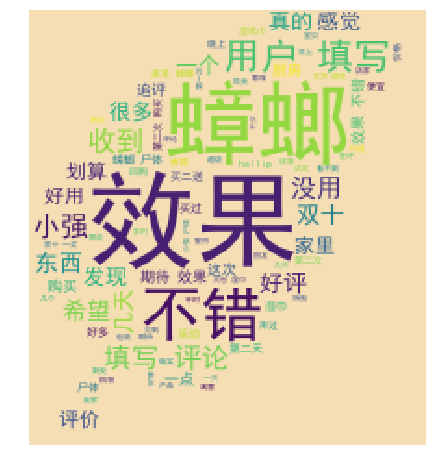

In [158]:
import imageio
from wordcloud import WordCloud

maskimg = imageio.imread(r'E:\千锋上海\data\leaf.jpg')


simhei_path = r'E:\千锋上海\data\simhei.ttf'  # 处理中文字体文件的路径
wc = WordCloud(font_path=simhei_path,
               background_color='wheat',
               mask=maskimg)  # 创建词云对象
wc.generate(comment_str)  # 传入评论字符串
plt.figure(figsize=(8,8))
plt.imshow(wc)  # 绘制词云
plt.axis('off')  # 关闭坐标轴
plt.show()

- 写出词云文件

In [159]:
wc.to_file(r'E:\千锋上海\data\拜耳舆情词云图.jpg')

- 基于TF-IDF的关键词提取

In [168]:
import jieba.analyse
jieba.analyse.extract_tags(comment_str,topK=20,withWeight=True)

[('蟑螂', 0.35868827490141125),
 ('效果', 0.2849843733535205),
 ('双十', 0.12792281324949317),
 ('小强', 0.09200132125972145),
 ('评论', 0.08243514073285675),
 ('湿巾', 0.0800848241710357),
 ('填写', 0.07859912763569854),
 ('不错', 0.07854611456578228),
 ('好评', 0.07205703576029969),
 ('追评', 0.06743985193350374),
 ('没用', 0.06355521640160776),
 ('收到', 0.06240940420464874),
 ('用户', 0.06013517913107095),
 ('好用', 0.05909939270004407),
 ('尸体', 0.05479502199496166),
 ('划算', 0.05456206954124107),
 ('湿纸巾', 0.05268657021031292),
 ('家里', 0.04667477953221154),
 ('发货', 0.04579483339359189),
 ('期待', 0.04317101167929661)]